In [1]:
from pikan.model_utils import GeneralizedMLP, PirateNet
from pikan.model_utils import get_mse_loss, get_train_step
from pikan.model_utils import KeyHandler, sobol_sample
from pikan.utils import load_dict_from_file, save_dict_to_file

from pikan.interpolated_funcs import circular_wave_interference

import yaml
import jax.numpy as jnp
import numpy as np
from flax import linen as nn
import optax
from functools import partial
from tqdm import tqdm
import pandas as pd

import jax
import pickle
import os

jax.devices()

[CpuDevice(id=0)]

In [2]:
def l2_error(results, true):
    err = jnp.sum((results - true)**2) / jnp.sum(true**2)
    err = jnp.sqrt(err)
    return err

def get_l2_error(config, variables):
    model = get_model(config)
    learnable_func = get_target_func(experiment)
    
    N = 300
    X_1 = jnp.linspace(experiment["X_MIN"], experiment["X_MAX"], N)
    X_2 = jnp.linspace(experiment["Y_MIN"], experiment["Y_MAX"], N)
    X_1, X_2 = jnp.meshgrid(X_1, X_2, indexing='ij')
    coords = jnp.stack([X_1.flatten(), X_2.flatten()], axis=1)

    y = learnable_func(coords).reshape(-1,1)

    if config["MODEL"] == "KAN":
        y_hat = model.apply(variables, coords)
    else:
        y_hat = model.apply({"params": variables["params"]}, coords)
        
    err = l2_error(y_hat, y)
    
    return err

def sum_params(data, verbose=False):
    total = 0
    if isinstance(data, type(jnp.array([]))):  # If the current node is a leaf array
        return len(data.reshape(-1))
    elif isinstance(data, dict):  # If the current node is a dictionary
        for key, value in data.items():
            if verbose:
                print(f"Processing key: {key}")  # Print the current key
            branch_total = sum_params(value)  # Compute the total for this subbranch
            if verbose:
                print(f"Total parameters in subbranch '{key}': {branch_total}")
            total += branch_total
    
    return total

In [81]:
def get_model(config):
    if config["MODEL"] == "MLP":
        return GeneralizedMLP(
            kernel_init=nn.initializers.glorot_normal(),
            num_input=config['N_INPUT'],
            num_output=1,
            use_fourier_feats=config['FourierFeatures'],
            layer_sizes=config['layers']
        )
    if config["MODEL"] == "KAN":
        from pikan.model_utils import FourierKAN
        
        return FourierKAN(
            kernel_init=nn.initializers.glorot_normal(),
            num_input=config['N_INPUT'],
            num_output=1,
            use_fourier_feats=config['FourierFeatures'],
            layer_sizes=config['layers']
        )
    if config["MODEL"] == "PIRATE":
        return PirateNet(
            kernel_init=nn.initializers.glorot_normal(),
            num_input=config['N_INPUT'],
            num_output=1,
            layer_sizes=config['layers'] # first is fourier
        )
    
def get_target_func(config):
    if config["learnable_func"] == "circular_wave_interference":
        learnable_func = circular_wave_interference

    learnable_func = partial(learnable_func, FREQ=config["FREQ"])
    return learnable_func

def sample_collocs(config):
    collocs = jnp.array(sobol_sample(np.array([config["X_MIN"],config["Y_MIN"]]), 
                                     np.array([config["X_MAX"],config["Y_MAX"]]), config["BS"]))
    return collocs

def train_model(config):    
    collocs = sample_collocs(config)

    model = get_model(config)
    variables = model.init(keygen.key(), collocs)
    loss_fn = get_mse_loss(model, MODEL=config["MODEL"])
    
    # Define a cosine decay learning rate schedule
    schedule_fn = optax.cosine_decay_schedule(
        init_value=1e-2,       # Initial learning rate
        decay_steps=config["EPOCHS"]+1,  # Total number of decay steps
        alpha=1e-3             # Final learning rate multiplier
    )
    optimizer = optax.adamw(learning_rate=schedule_fn, weight_decay=1e-4)
    opt_state = optimizer.init(variables['params'])
    train_step = get_train_step(model, optimizer, loss_fn)

    learnable_func = get_target_func(config)

    if config["MODEL"] != "KAN":
        variables["state"] = []

    # train always on same colloc points
    collocs = sample_collocs(experiment)
    losses = []

    if experiment["EPOCHS"]:
        loc_w = jnp.array([])
        for i in (pbar:= tqdm(range(experiment["EPOCHS"]))):
            params, state = variables['params'], variables['state']
            y = learnable_func(collocs).reshape(-1,1)
            params, opt_state, loss, loc_w = train_step(params, collocs, y,
                                                        opt_state, state, loc_w)
            variables = {'params': params, 'state':state}
    
            losses.append(loss)
    
            if i % 50 == 0: # dont waste a lot of time printing
                pbar.set_description(f"Loss {loss: .8f}")

    return variables, collocs, learnable_func, loss_fn

In [90]:
# filename = "increase_freq_KAN_Fourier"
# filename = "increase_freq_PIRATE"
filename = "loss_landscape"

with open(f"yaml_configs/{filename}.yaml", 'r') as file:
    config = yaml.safe_load(file)

keygen = KeyHandler(0)
config["experiments"].keys()

dict_keys(['trained', 'untrained', 'trained_no_fourier', 'super_deep'])

In [91]:
for exp_key in config["experiments"].keys():
    experiment = config["experiments"][exp_key]

    collocs = sample_collocs(experiment)
    model = get_model(experiment)
    variables = model.init(keygen.key(), collocs)

    print(exp_key)
    print(sum_params(variables["params"], verbose=False))

trained
49857
untrained
50049
trained_no_fourier
50049
super_deep
3577


In [92]:
import time

utils = {}
elapsed_times = []
for exp_key in config["experiments"].keys():
    experiment = config["experiments"][exp_key]
    start_time = time.time()
    variables, collocs, learnable_func, loss_fn = train_model(experiment)
    
    model = get_model(experiment)
    utils[exp_key] = (variables, model, collocs, learnable_func)
    
    end_time = time.time()
    
    save_dict_to_file(variables, f"results/models/{filename}", f"{exp_key}")
    elapsed_times.append(end_time - start_time)

print("Elapsed times for each iteration:", elapsed_times)

Loss  0.34061927: 100%|██████████████████████| 500/500 [00:02<00:00, 213.00it/s]

Elapsed times for each iteration: [3.342489242553711, 0.015892982482910156, 2.4257280826568604, 2.388205051422119]


  0%|                                                     | 0/4 [00:00<?, ?it/s]

trained


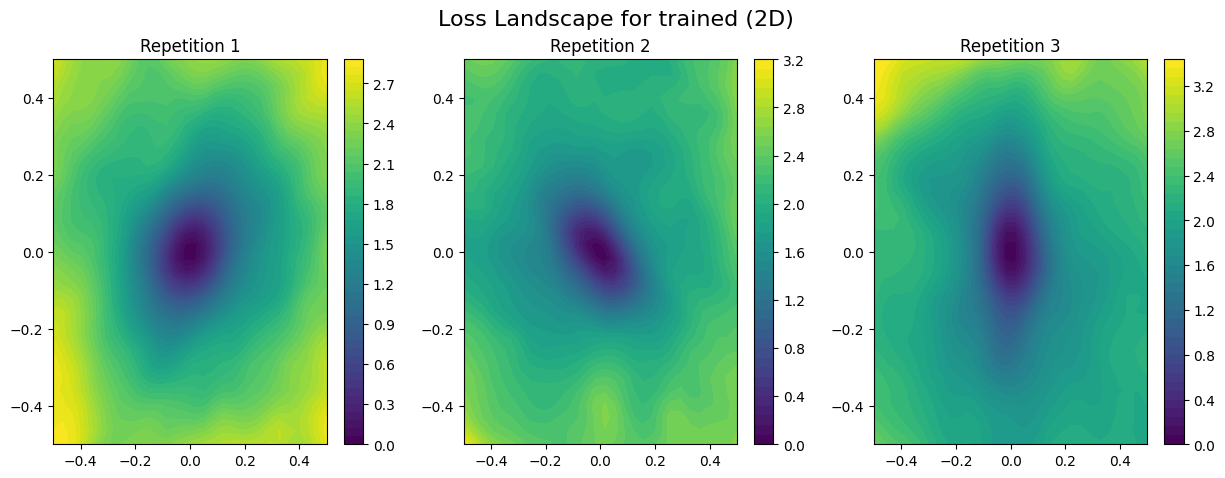

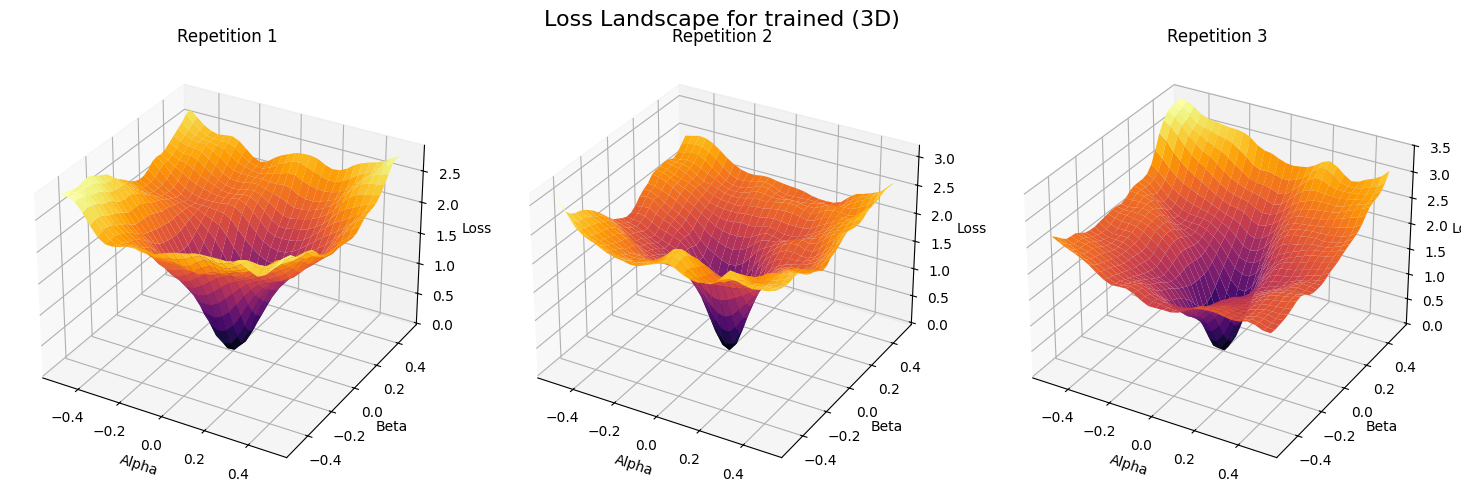

 25%|███████████▎                                 | 1/4 [00:08<00:26,  8.75s/it]

untrained


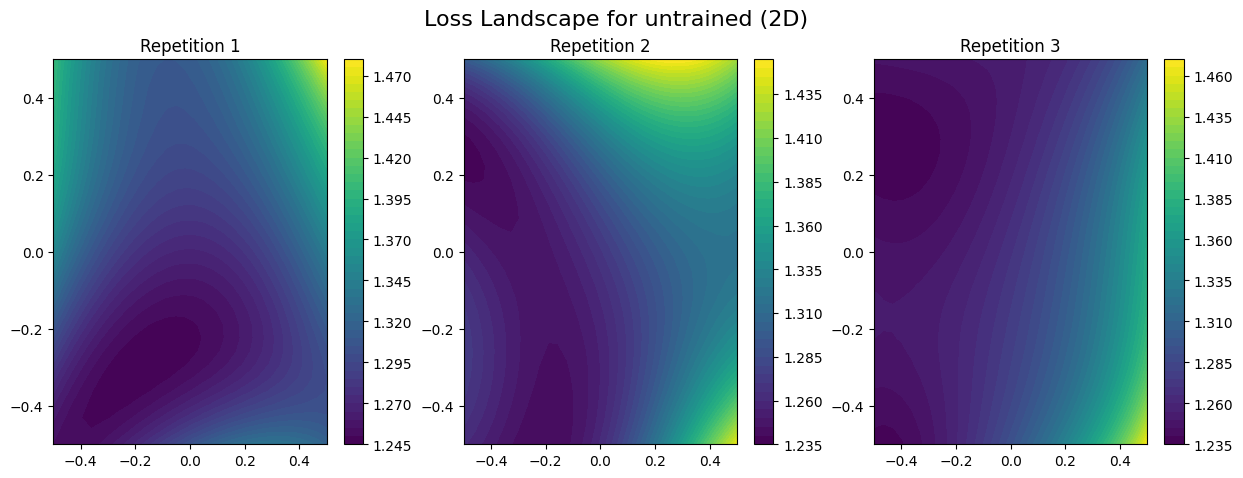

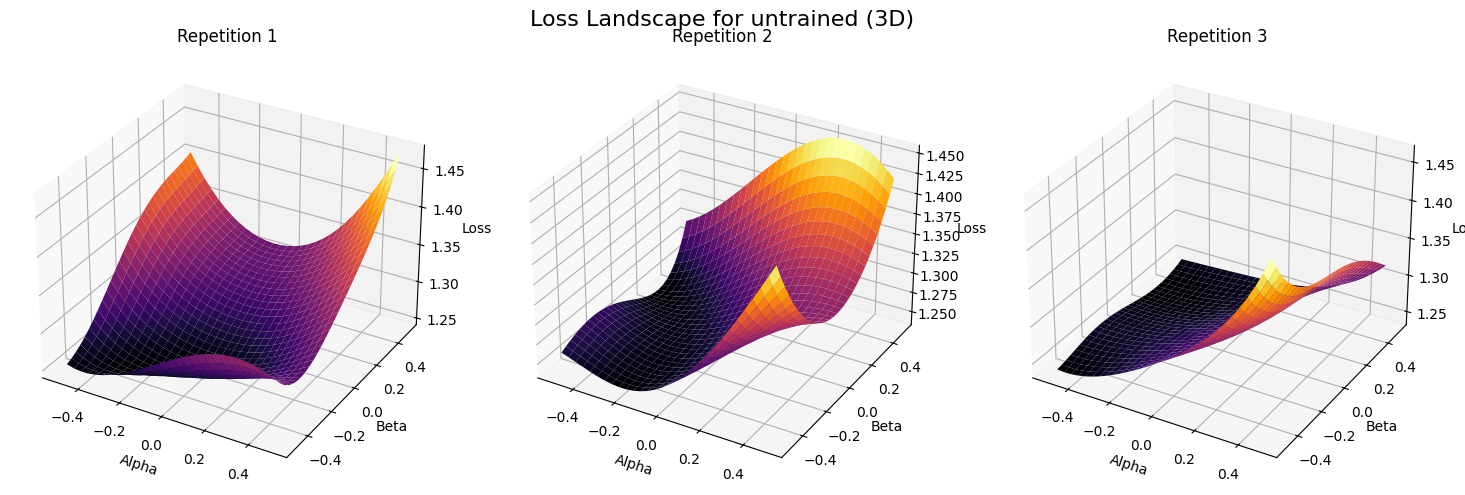

 50%|██████████████████████▌                      | 2/4 [00:16<00:15,  7.99s/it]

trained_no_fourier


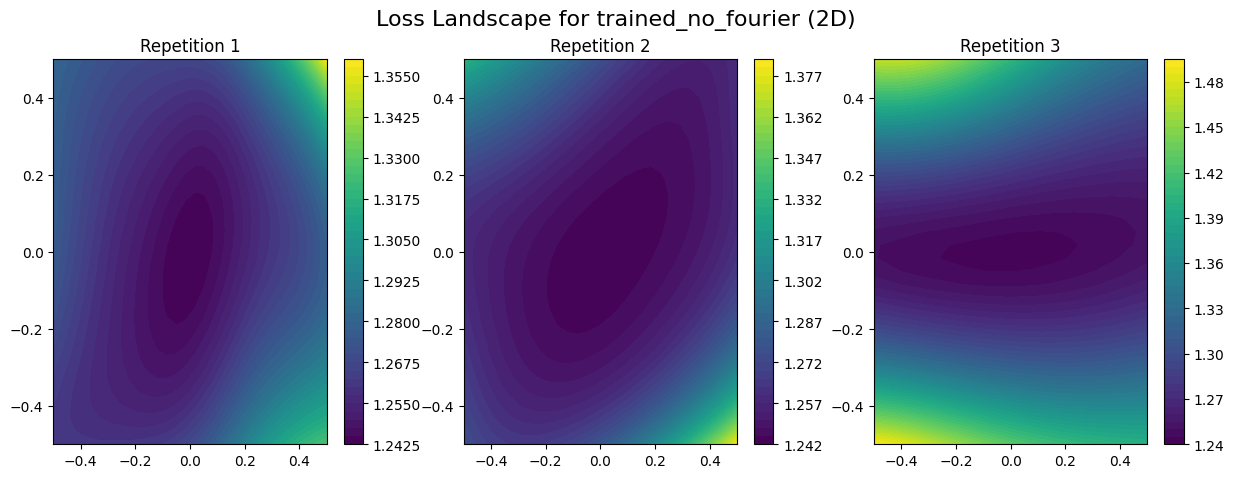

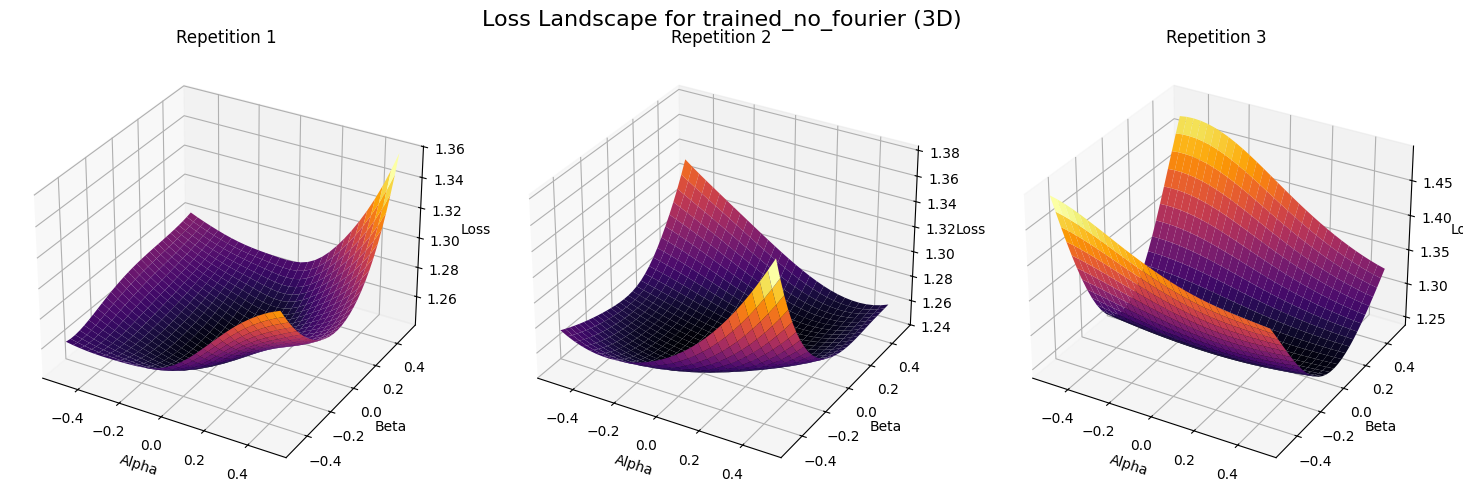

 75%|█████████████████████████████████▊           | 3/4 [00:24<00:07,  7.93s/it]

super_deep


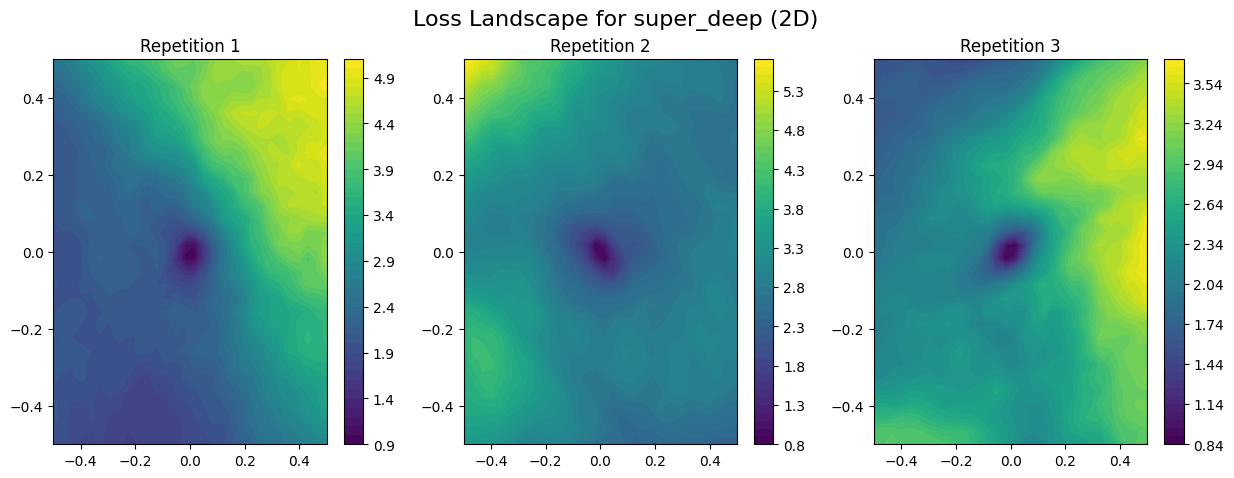

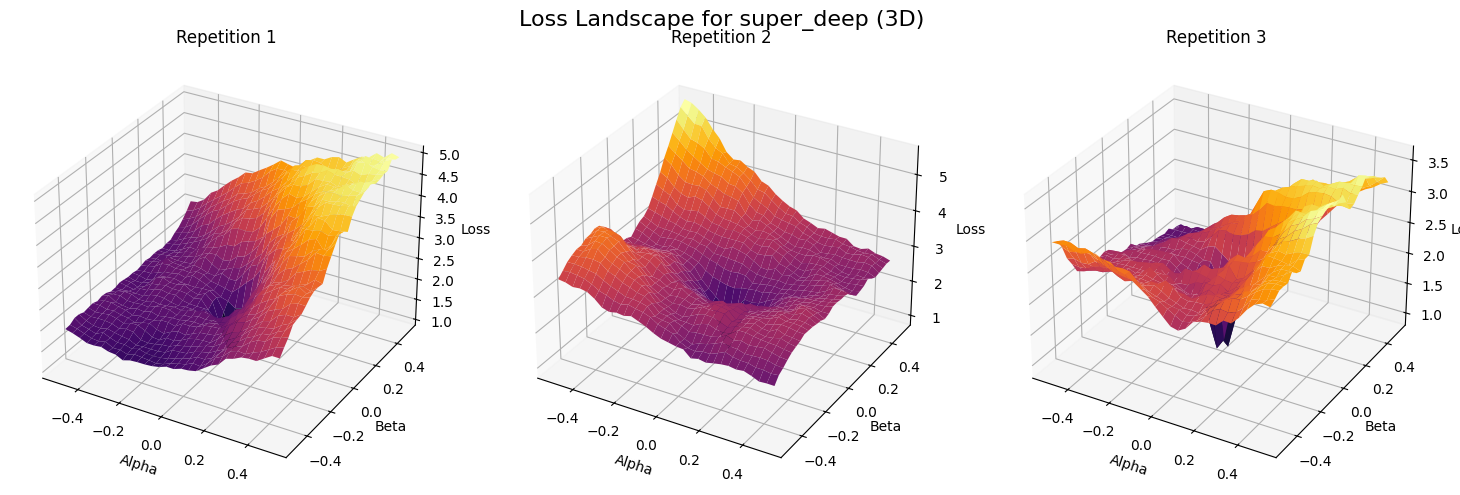

100%|█████████████████████████████████████████████| 4/4 [00:27<00:00,  6.93s/it]


In [93]:
import warnings
from mpl_toolkits.mplot3d import Axes3D
warnings.filterwarnings("ignore")

# Function to plot the loss landscape (2D and 3D)
def plot_loss_landscape(grid_x, grid_y, loss_values, title, exp_key, ax=None, plot_3d=False):
    # Create meshgrid
    X_grid, Y_grid = np.meshgrid(grid_x, grid_y)
    
    if ax is None:
        fig = plt.figure(figsize=(10, 7))
        if plot_3d:
            ax = fig.add_subplot(111, projection='3d')
        else:
            ax = fig.add_subplot(111)
    
    if plot_3d:
        # Plot the 3D surface
        surf = ax.plot_surface(
            X_grid, Y_grid, loss_values, cmap='inferno', antialiased=True, edgecolor='none'
        )
        ax.set_zlabel('Loss')
        # Add labels and title
        ax.set_xlabel('Alpha')
        ax.set_ylabel('Beta')
    else:
        # Plot the 2D contour
        contour = ax.contourf(X_grid, Y_grid, loss_values, levels=50, cmap='viridis')
        plt.colorbar(contour, ax=ax)
        
    ax.set_title(title)

    # Save the figure
    if ax is None:
        fig.savefig(f'results/visuals/loss_landscapes/{exp_key}')
        plt.show()

# Main loop
loss_landscape = True

if loss_landscape:
    for key, aux in tqdm(utils.items()):
        variables, model, collocs, learnable_func = aux
        print(key)
        
        # Create a figure with subplots for each repetition (2D and 3D)
        fig_2d, axes_2d = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns for 2D plots
        fig_3d = plt.figure(figsize=(15, 5))  # Separate figure for 3D plots
        fig_2d.suptitle(f'Loss Landscape for {key} (2D)', fontsize=16)
        fig_3d.suptitle(f'Loss Landscape for {key} (3D)', fontsize=16)
        
        for repetition in range(3):
            grid_x, grid_y, loss_vals = compute_loss_landscape(variables["params"], model, 
                                                              collocs, learnable_func(collocs), res=.5)
            
            # Plot the 2D loss landscape on the corresponding subplot
            plot_loss_landscape(grid_x, grid_y, loss_vals, f'Repetition {repetition + 1}', 
                               f'{key}_{repetition}_2d', ax=axes_2d[repetition], plot_3d=False)
            
            # Plot the 3D loss landscape
            ax_3d = fig_3d.add_subplot(1, 3, repetition + 1, projection='3d')
            plot_loss_landscape(grid_x, grid_y, loss_vals, f'Repetition {repetition + 1}', 
                               f'{key}_{repetition}_3d', ax=ax_3d, plot_3d=True)
        
        # Adjust layout to minimize blank space
        plt.tight_layout()
        
        # Save and show figures
        fig_2d.savefig(f'results/visuals/loss_landscapes/{key}_2d')
        fig_3d.savefig(f'results/visuals/loss_landscapes/{key}_3d')
        plt.show()

In [ ]:
import pandas as pd

df = pd.DataFrame(config["experiments"]).T
df["params"] = -1
df["L2%"] = -1

for idx, exp_key in enumerate(config["experiments"].keys()):
    experiment = config["experiments"][exp_key]
    
    variables = load_dict_from_file(f"results/models/{filename}/{exp_key}")
    l2_err = get_l2_error(experiment, variables)

    df.loc[exp_key, "params"] = sum_params(variables["params"], verbose=False)
    df.loc[exp_key, "L2%"] = l2_err * 100
    df['seconds'] = elapsed_times
    
    print(f"Results from {exp_key}:")
    print(f"L2 {l2_err*100:.4f}%")
    print(f"#params {df.iloc[idx]['params']}")
    
df.to_csv(f"results/csvs/{filename}")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from matplotlib import cm
import os

def plot_true_approx(config, variables, save_folder, exp_key):
    model = get_model(config)
    learnable_func = get_target_func(config)  # Fixed to use 'config' instead of 'experiment'
    
    N = 300
    X_1 = jnp.linspace(config["X_MIN"], config["X_MAX"], N)  # Fixed to use 'config'
    X_2 = jnp.linspace(config["Y_MIN"], config["Y_MAX"], N)  # Fixed to use 'config'
    X_1, X_2 = jnp.meshgrid(X_1, X_2, indexing='ij')
    coords = jnp.stack([X_1.flatten(), X_2.flatten()], axis=1)

    y = learnable_func(coords).reshape(-1, 1)
    if config["MODEL"] == "KAN":
        y_hat = model.apply(variables, coords)
    else:
        y_hat = model.apply({"params": variables["params"]}, coords)

    y_hat = y_hat.reshape(-1, 1)

    # Compute the absolute error
    abs_error = jnp.abs(y - y_hat).reshape(-1, 1)

    # Create a figure and axis grid for the 3 subplots
    fig = plt.figure(figsize=(18, 6))

    # Plotting the approximated function (y_hat) on the left using the plasma colormap
    ax1 = fig.add_subplot(1, 3, 1, projection='3d')
    ax1.plot_trisurf(coords[:, 0], coords[:, 1], y_hat.flatten(), cmap=cm.plasma)
    ax1.set_title('Approximated Function (y_hat)')
    ax1.set_xlabel('X1')
    ax1.set_ylabel('X2')
    ax1.set_zlabel('y_hat')

    # Plotting the true function (y) in the middle
    ax2 = fig.add_subplot(1, 3, 2, projection='3d')
    ax2.plot_trisurf(coords[:, 0], coords[:, 1], y.flatten(), cmap='viridis')
    ax2.set_title('True Function (y)')
    ax2.set_xlabel('X1')
    ax2.set_ylabel('X2')
    ax2.set_zlabel('y')

    # Plotting the absolute error on the right
    ax3 = fig.add_subplot(1, 3, 3, projection='3d')
    ax3.plot_trisurf(coords[:, 0], coords[:, 1], abs_error.flatten(), cmap='inferno')
    ax3.set_title('Absolute Error')
    ax3.set_xlabel('X1')
    ax3.set_ylabel('X2')
    ax3.set_zlabel('Error')

    # Adjust layout to ensure all plots fit well within the figure
    plt.tight_layout(pad=3.0)

    # Saving the figure
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)
    save_path = os.path.join(save_folder, f'{exp_key}_plot.png')

    # Save the plot to the specified path
    fig.savefig(save_path)

    # Explicitly close the plot to prevent it from showing
    plt.close(fig)

In [ ]:
from concurrent.futures import ThreadPoolExecutor
import matplotlib
# matplotlib.use('Agg')

def process_experiment(exp_key):
    try:
        experiment = config["experiments"][exp_key]
        print(f"Results from {exp_key}:")
        variables = load_dict_from_file(f'results/models/{filename}/{exp_key}')
        plot_true_approx(experiment, variables, f"results/visuals/{filename}", exp_key)
    except Exception as e:
        print(f"Error processing {exp_key}: {e}")

with ThreadPoolExecutor(max_workers=1) as executor:
    # Ensure we exhaust the map generator
    list(executor.map(process_experiment, config["experiments"].keys()))

In [ ]:
display(pd.read_csv('results/csvs/increase_freq_fourier').tail(3))

display(pd.read_csv('results/csvs/increase_freq_KAN_Fourier').tail(3))